In [5]:
import torch
import numpy as np
seed = 37
torch.manual_seed(seed)
np.random.seed(seed)

import sys
sys.path.append("../../../")
from pipeline.dataset.dataset_loader import DatasetLoader
import pandas as pd
from darts.models import (
    BlockRNNModel,
)
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import rho_risk
import matplotlib.pyplot as plt
import tsaug
import ray
from ray import tune
import os
from matplotlib.pyplot import figure

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["LD_LIBRARY_PATH"] = "/home/jupyter-babakesistani/.conda/envs/thesis/lib/"

figure(figsize=(8, 4), dpi=120)


dl =  DatasetLoader( '../../data/alibaba_minutely_cpu_gpu_mem_usage.csv', "Time",
                                                                    [
                                                                      "cpu_usage",
                                                                      "gpu_wrk_util",
                                                                      "avg_gpu_wrk_mem"
                                                                     ],
                    resample_freq="1min", augment=False, 
                    shift_df_datetime="2022-01-02 18:27:00",
                    fill_missing_dates=True)
train, val = dl.get_train_val_by_date("2022-02-14 23:59:00")


<Figure size 960x480 with 0 Axes>

In [5]:
def training_function(config):
    quantiles = [0.1, 0.5, 0.9]

    model = BlockRNNModel(
        model="LSTM",
        input_chunk_length=config["input_chunk_length"],
        output_chunk_length=config["output_chunk_length"],
        hidden_size=25,
        n_rnn_layers=2,
        batch_size=256,
        n_epochs=20,
        dropout=0.1,
        save_checkpoints=True,
         add_encoders={
        'cyclic': {'past': ['day','dayofweek', 'hour', 'minute']},
        "datetime_attribute": {"past": ["month"]},
        'transformer': Scaler()
        },
        likelihood=QuantileRegression(
            quantiles=quantiles
        ), 
        work_dir="logs/LSTM_usage_minute_hparam",
        nr_epochs_val_period=1,
        optimizer_kwargs={"lr": 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True,
        torch_device_str='cuda:0'
    )
    
    model.fit(train, val_series=val)
    pred = model.predict(series=val[:config["input_chunk_length"]], n=24*60*5, num_samples=100)
    rr = 0.0
    for rho in quantiles:
        rr += rho_risk(val[config["input_chunk_length"]:], pred, rho=rho)
    rr = rr / len(quantiles)
    
    tune.report(mean_loss=rr)

In [ ]:
max_concurrent_trials = 8
analysis = tune.run(
    training_function,
    max_concurrent_trials=max_concurrent_trials,
    resources_per_trial={'cpu': 8.0/max_concurrent_trials, 'gpu': 1.0/max_concurrent_trials},
    local_dir="logs/lstm_hparam",
    progress_reporter=tune.JupyterNotebookReporter(overwrite=True),
    config={
        "input_chunk_length": tune.grid_search([15, 30, 60, 90, 120, 360]),
        "output_chunk_length": tune.grid_search([15, 30, 60, 90, 120, 360]),
#         "hidden_size": tune.grid_search([25, 75]),
# #         "n_rnn_layers": tune.grid_search([2]),
#         "batch_size": tune.grid_search([512]),
#         "dropout": tune.grid_search([0.1]),
    })

print("Best config: ", analysis.get_best_config(
    metric="mean_loss", mode="min"))

# Get a dataframe for analyzing trial results.
df = analysis.results_df

Trial name,status,loc,input_chunk_length,output_chunk_length,loss,iter,total time (s),neg_mean_loss
training_function_9b01a_00002,RUNNING,130.149.248.55:1032802,60,15,,,,
training_function_9b01a_00003,RUNNING,130.149.248.55:1032801,90,15,,,,
training_function_9b01a_00004,RUNNING,130.149.248.55:1032800,120,15,,,,
training_function_9b01a_00005,RUNNING,130.149.248.55:1032807,360,15,,,,
training_function_9b01a_00008,RUNNING,130.149.248.55:1032796,60,30,,,,
training_function_9b01a_00009,RUNNING,130.149.248.55:1032795,90,30,,,,
training_function_9b01a_00010,RUNNING,130.149.248.55:1032798,120,30,,,,
training_function_9b01a_00011,RUNNING,130.149.248.55:1032803,360,30,,,,
training_function_9b01a_00000,TERMINATED,130.149.248.55:1032797,15,15,0.374152,1,555.249,-0.374152
training_function_9b01a_00001,TERMINATED,130.149.248.55:1032794,30,15,0.404857,1,591.182,-0.404857


In [5]:
model.fit(train, val_series=val, verbose=True)

[2022-04-07 21:13:08,344] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 79554 samples.
[2022-04-07 21:13:08,344] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 79554 samples.
[2022-04-07 21:13:08,368] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-04-07 21:13:08,368] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/100 [00:00<?, ?it/s]

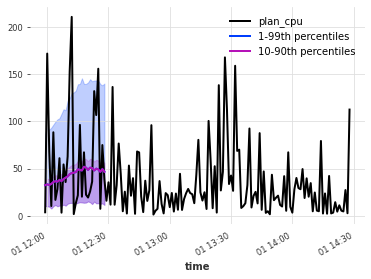

<Figure size 960x480 with 0 Axes>

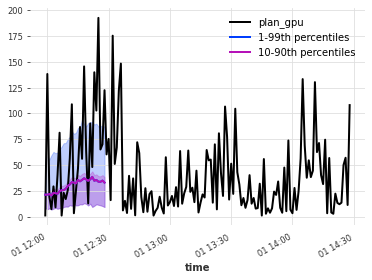

<Figure size 960x480 with 0 Axes>

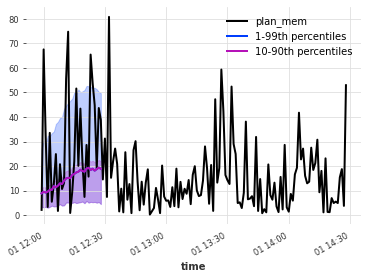

<Figure size 960x480 with 0 Axes>

In [59]:
cut_off = 1440//2
pred_len = 30
pred = model.predict(series=val[:cut_off], n=pred_len, num_samples=100)
pred = dl.scaler.inverse_transform(pred)
val_back = dl.scaler.inverse_transform(val)
for i in range(pred.n_components):
    val_back[cut_off:cut_off+pred_len+120].univariate_component(i).plot()
    pred.univariate_component(i).plot(low_quantile=0.05, high_quantile=0.95, label="1-99th percentiles")
    pred.univariate_component(i).plot(low_quantile=0.1, high_quantile=0.9,  label="10-90th percentiles")
    figure(figsize=(8, 4), dpi=120)
    plt.savefig(str(i))
    plt.show()